# In-Depth Analysis 

## Loading Modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split 

## Importing the data

In [2]:
recipes_df=pd.read_csv('recipes_df.csv')
recipes_df.set_index('id', inplace=True)
reviews_df=pd.read_csv('reviews_df.csv')
reviews_df.set_index('recipe_id', inplace=True)
tags_matrix=pd.read_csv('tags_matrix.csv')
tags_matrix.set_index('id', inplace=True)
ingredients_matrix=pd.read_csv('ingredients_matrix.csv')
ingredients_matrix.set_index('id', inplace=True)

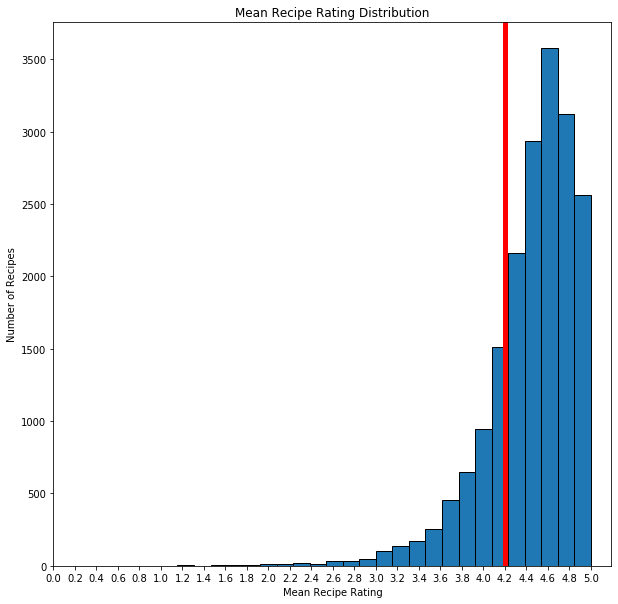

In [3]:
_ = plt.figure(figsize=(10,10))
x_range=[0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,
         2.0,2.2,2.4,2.6,2.8,3.0,3.2,3.4,3.6,3.8,
         4.0,4.2,4.4,4.6,4.8,5.0]
_ = plt.hist(reviews_df.groupby('recipe_id')['rating'].mean(), edgecolor='black', bins=25)#(len(x_range)-1)#np.arange(, 5, 0.20))
_ = plt.title('Mean Recipe Rating Distribution')
_ = plt.xlabel('Mean Recipe Rating')
_ = plt.ylabel('Number of Recipes')
_ = plt.xticks(x_range)
_ = plt.axvline(x=4.2, linewidth=5, color='r')

Based on the histogram above we decided to arbitrarily choose a mean rating of 4.2 as a threshold for "good" vs "bad" recipes.

In [4]:
print('Number of "good" recipes with rating >=4.2 = '
      +str(len(reviews_df.index[reviews_df.rating>=4.2]))+'\n'
      +'Number of "bad" recipes with rating < 4.2 = '
      +str(len(reviews_df.index[reviews_df.rating < 4.2])))

Number of "good" recipes with rating >=4.2 = 434232
Number of "bad" recipes with rating < 4.2 = 143605


There are 3 times more recipes labeled as "good", so we have a class imbalance situation. It will impact our choice of model accuracy metrics later.

## Random Forest

First, we need to create a combined_df containing all the features in one dataset.

In [19]:
combined_df=recipes_df[['minutes','n_steps','Calories','Total Fat','Sugars',
           'Sodium','Protein','Saturated Fat',
            'Total Carbohydrate']].merge(ingredients_matrix, right_index=True,left_index=True)
combined_df=combined_df.merge(tags_matrix,right_index=True,left_index=True)
combined_df=combined_df.join(avg_rating, how='left')
combined_df.head(3)

,minutes,n_steps,Calories,Total Fat,Sugars,Sodium,Protein,Saturated Fat,Total Carbohydrate,flour,...,'spreads','tropical-fruit','cauliflower','canning','15-minutes-or-less','mixer','chowders','pressure-canning','plums',rating
id,,,,,,,,,,,,,,,,,,,,,
63986,500,5,105.7,8.0,0.0,26.0,5.0,4.0,3.0,1,...,0,0,0,0,0,0,0,0,0,4.368421
43026,45,9,94.0,10.0,0.0,11.0,11.0,21.0,0.0,0,...,0,0,0,0,0,0,0,0,0,4.045455
23933,15,4,232.7,21.0,77.0,4.0,6.0,38.0,8.0,0,...,0,0,0,0,0,0,0,0,0,4.833333


Now we have data with 653 features. Now let's use a Random Forest classifier on the dataset to classify the recipes as "good" (e.g. average rating > 4.2) or "bad".

In [43]:
combined_df['rating1'] = combined_df.rating.apply(lambda x: 1 if x >= 4.2 else 0)
samples=combined_df.iloc[:,:-2].values

In [70]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
X=samples
y=combined_df.rating1.values.astype(np.int)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3, random_state=42)

y_pred = rf.fit(X_train,y_train).predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report, fbeta_score
print("Classification Report:\n\n",classification_report(y_test, y_pred, labels=[0, 1]))
print("\nConfusion Matrix:\n\n",confusion_matrix(y_test, y_pred))
print("\nFbeta Score:",fbeta_score(y_test, y_pred, beta=0.5))

C:\Users\anna_\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Classification Report:

               precision    recall  f1-score   support

           0       0.33      0.14      0.19      1166
           1       0.80      0.93      0.86      4463

    accuracy                           0.76      5629
   macro avg       0.57      0.53      0.53      5629
weighted avg       0.71      0.76      0.72      5629


Confusion Matrix:

 [[ 159 1007]
 [ 327 4136]]

Fbeta Score: 0.8260435390453366


Random Forest model's F1 scores are slightly worse than those of tuned in Naive Bayes model (18% vs 22% on the training data, stayed same on the test data). The number of True Positives is higher in Random Forest (398 vs 365), but the number of True Negatives is lower (4,065 vs 4,098)

### Feature Importances

Let's review top 20 most important features by using sklearn feature_importances_

In [62]:
zipped = zip(combined_df.iloc[:,:-2].columns,rf.feature_importances_)
res = sorted(zipped, key = lambda x: x[1], reverse=True)
for i in res[0:20]:
    print(res.index(i), i)

0 ('Sugars', 0.03647437868351507)
1 ('Calories', 0.03335663059954855)
2 ('minutes', 0.032325083244303936)
3 ('Protein', 0.03216501938712848)
4 ('Sodium', 0.02918910214413097)
5 ('n_steps', 0.028909837834085322)
6 ('Total Fat', 0.02865255769966964)
7 ('Total Carbohydrate', 0.027698069065659355)
8 ('Saturated Fat', 0.027534647161752687)
9 ('salt', 0.007157547639489193)
10 (" 'occasion'", 0.006609486694509244)
11 (" 'easy'", 0.006517868291914836)
12 (" 'cuisine'", 0.006407414491322801)
13 (" 'low-in-something'", 0.006327640510926335)
14 (" 'number-of-servings'", 0.006267027396586806)
15 (" 'equipment'", 0.0059728176786675875)
16 (" 'taste-mood'", 0.005692089915442195)
17 ('oil', 0.005591656180447823)
18 ("'60-minutes-or-less'", 0.0055337084192794385)
19 ('flour', 0.005496337023658287)


We can see that all nutritional values and an ingredient called "salt" are the top 10 most important features to predict the goodness of the recipe average rating.

### Tuning in Hyperparameters

Let's see if we can improve Random Forest model's predictions by tuning in the hyperparameters:
- n_estimators (default is 10 in our version of sklearn). 
- max_depth (default=None) The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
- min_samples_split (default=2) The minimum number of samples required to split an internal node
- min_samples_leaf (default=1) The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.
- min_weight_fraction_leaf (default=0.) The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided.
- max_features (default=”auto”) The number of features to consider when looking for the best split 

<br> We will use GridSearch to tune in multiple parameters at a time, and will use ROC_AUC score as our accuracy metric.

In [82]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [10, 50, 100]
             ,'max_depth': [3, 7, 11]
             ,'min_samples_split': [2, 5]
             ,'min_samples_leaf': [1, 3]
             ,'min_weight_fraction_leaf': [0, 0.25]
             ,'max_features': [5, 10, 20]} 

rf = RandomForestClassifier()
rf_cv = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc') 
rf_cv.fit(X, y) 
rf_cv.best_params_

{'max_depth': 11,
 'max_features': 20,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0,
 'n_estimators': 100}

In [83]:
rf_cv.best_score_

0.6332955223412016

The best combination of parameters produces the best average score of all cv folds equal to 63% with Random Forest classifier model.

## Logistic regression 

Let's use a Logistic Regression to predict recipe rating being 'good' or 'bad'

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
logreg = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

C:\Users\anna_\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Feature Importances

Let's review top 20 most important features by using sklearn feature_importances_

In [89]:
zipped = zip(combined_df.iloc[:,:-2].columns,logreg.feature_importances_)
res = sorted(zipped, key = lambda x: x[1], reverse=True)
for i in res[0:20]:
    print(res.index(i), i)

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'